# QieList

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../")

## Building Sampling Frame

### Idiom List (in ngrams)

In [2]:
import local_config
import pickle
from functools import partial, reduce
import pandas as pd
import numpy as np
from MWE2019.materials import NGram4List, MoeIdioms
from MWE2019.corpus import CorpusFactory
from MWE2019.corpus_index import CorpusIndex
from MWE2019.utils import get_cache_path, install_data_cache
from tqdm import tqdm_notebook as tqdm

In [3]:
ng = NGram4List()

NGram4List loaded:  E:\LangOn\MWE2019\data\cache_ngrams_list\ngrams_var_list.csv


In [4]:
idioms = MoeIdioms()

initialize new instance


In [5]:
ng.merged_df.head()

,freq,sub2.A,del2.A,sub3.A,del3.A,ins.A,sub2.C,del2.C,sub3.C,del3.C,ins.C,sub2.P,del2.P,sub3.P,del3.P,ins.P,pmi
ngram,,,,,,,,,,,,,,,,,
台北報導,206875,244,2,0,0,22,233,0,0,0,6,0,0,0,0,0,-46.299180
資料來源,121438,15,0,0,0,16,4,0,0,0,1,0,0,0,0,0,-44.669832
綜合報導,112063,0,0,0,0,308,0,0,0,0,59,0,0,0,0,0,-43.862106
中華民國,58360,3,0,8,11,55,2,0,1,2,26,2,0,1,0,51,-48.729690
最重要的,35402,38,0,16,11,33,28,0,6,1,20,61,1,9,2,98,-51.222036


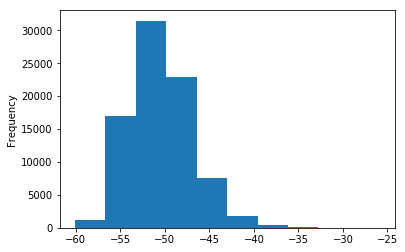

In [6]:
ng.merged_df.pmi.plot(kind='hist')

In [7]:
enc_seeds = ng.merged_df.sort_values("pmi", ascending=False).iloc[:int(ng.merged_df.shape[0]/2), :].reset_index()["ngram"]
enc_seeds = enc_seeds.loc[('?' not in x for x in enc_seeds)]
install_data_cache('enclosing_ngrams')
seed_path = get_cache_path('enclosing_ngrams', f"enclosing_seed.csv")
enc_seeds.to_csv(seed_path, index=False)


## merging enclosings

In [8]:
from MWE2019.materials import compute_enclosing

In [9]:
enc_df = compute_enclosing(ng.merged_df)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("sub")], inplace=True)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("del")], inplace=True)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("ins")], inplace=True)
enc_df = enc_df.loc[enc_df.enc_freq > 0]

In [10]:
enc_df["enc_norm"] = np.log(enc_df.enc_freq/enc_df.freq)

In [25]:
enc_df["enc_norm_pr"] = enc_df.enc_norm.rank(ascending=False, pct=True)
enc_df["pmi_pr"] = enc_df.pmi.rank(pct=True)
enc_df = enc_df.loc[(enc_df.enc_norm_pr>=0.75) & (enc_df.pmi_pr >= 0.75), :]
qie_df = enc_df.loc[(x for x in enc_df.index if x not in idioms), :]
qie_df.index.name = "ngram"

In [38]:
print(enc_df.shape)
print(qie_df.shape)

(2722, 6)
(2478, 6)


In [37]:
install_data_cache("qie_list")
qie_path = get_cache_path("qie_list", "qie_list.csv")
qie_df.to_csv(qie_path, index=True)

## Generate QieContext Sentences

In [4]:
apple = CorpusFactory.GetNewsCorpus(local_config.CORPUS_DIR + "/Apple_text")

In [5]:
from MWE2019.materials import RedisCorpus
from MWE2019.materials import QieContext
from itertools import takewhile

In [45]:
from random import random
arts = list(filter(lambda x: random() < 0.01, apple.articles()))

In [51]:
corpus_index = CorpusIndex('apple_dbg', arts)


try loading index...


Saving index...Done


In [52]:
ctx = QieContext(arts, corpus_index)

In [57]:
cc = ctx.search_context('嚴重毀損')

In [60]:
cc

['高市文化局文化資產中心主任林尚瑛說，會勘後發現旗山生活文化園區北棟教室、辦公室及禮堂等建築均嚴重毀損，窗框、樑柱多處龜裂，毀損狀況已有立即性危險']